# Classes

In [141]:
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader as pdr
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Load Data

In [154]:
# 3 Different sectors
company1 = 'AAPL'
company2 = 'KO'
company = 'ATVI'

# Start and end time
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2021, 12, 22)

# Collecting data from yahoo finance
stockData = pdr.DataReader(company, 'yahoo', start, end)
stockData

High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2012-01-03  12.490000  12.190000  12.460000  12.200000  10330200.0  11.129882
2012-01-04  12.270000  12.070000  12.210000  12.110000   8551600.0  11.047776
2012-01-05  12.210000  11.940000  12.120000  12.110000   8809800.0  11.047776
2012-01-06  12.310000  11.980000  12.090000  12.240000   9625000.0  11.166373
2012-01-09  12.240000  12.030000  12.230000  12.200000   5827500.0  11.129882
...               ...        ...        ...        ...         ...        ...
2021-12-16  61.630001  60.180000  60.549999  61.490002  10074500.0  61.126659
2021-12-17  62.070000  60.599998  61.099998  61.360001  16960300.0  60.997425
2021-12-20  62.230000  60.669998  61.009998  61.799999   8369400.0  61.434826
2021-12-21  63.639999  61.860001  62.250000  63.590000  11097700.0  63.214249
2021-12-22  64.120003  63.139999  63.259998  64.099998  15089700.0  63.721233

[2511 rows x 6 columns]

# Clean Data

### Scale Data

In [155]:
# Data will be between 0 and 1 to make it easier to work with
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale those 0 - 1 values to only use the closed data
scaledData = scaler.fit_transform(stockData['Close'].values.reshape(-1, 1))
scaledData

array([[0.01758713],
       [0.01662198],
       [0.01662198],
       ...,
       [0.54949062],
       [0.56868634],
       [0.57415549]])

# Setup Training

In [156]:
# How many days does it look into the past to make the prediction
predictionDays = 60 
#predictionDays = 180 
#predictionDays = 365 

In [157]:
# Initalize and append datas to the x and y training data
xTrain = []
yTrain = []

# Append last predictionDay # value to xTrain and then yTrain will hold the + 1 value to check if it is training correctly
for day in range(predictionDays, len(scaledData)):
    xTrain.append(scaledData[day - predictionDays : day, 0])
    yTrain.append(scaledData[day, 0])

### Convert Arrays

In [158]:
# Converting x and y Train arrays into numpy arrays
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)

xTrain.shape

(2451, 60)

### Reshape


In [159]:
# Reshape xTrain into a 3D usable value for neural network
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
#xTrain

# Create Neural Network 

In [160]:
# Create Models
model = Sequential()

## Testing

In [161]:
# Fill in models
unitAmount = 50

model.add(LSTM(units = unitAmount, return_sequences=True, input_shape = (xTrain.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = unitAmount, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = unitAmount))
model.add(Dropout(0.2))

# Model to add prediction of future
model.add(Dense(units = 1))

# Optimize the model
model.compile(optimizer = 'adam', loss='mean_squared_error')

# Adding the training data to the model
model.fit(xTrain, yTrain, epochs = 30, batch_size = 32)

Epoch 1/30
77/77 [==============================] - 6s 45ms/step - loss: 0.0113
Epoch 2/30
77/77 [==============================] - 9s 116ms/step - loss: 0.0032
Epoch 3/30
77/77 [==============================] - 13s 166ms/step - loss: 0.0027
Epoch 4/30
77/77 [==============================] - 12s 152ms/step - loss: 0.0024
Epoch 5/30
77/77 [==============================] - 11s 141ms/step - loss: 0.0022
Epoch 6/30
77/77 [==============================] - 12s 153ms/step - loss: 0.0027
Epoch 7/30
77/77 [==============================] - 12s 157ms/step - loss: 0.0023
Epoch 8/30
77/77 [==============================] - 11s 146ms/step - loss: 0.0020
Epoch 9/30
77/77 [==============================] - 11s 149ms/step - loss: 0.0021
Epoch 10/30
77/77 [==============================] - 12s 150ms/step - loss: 0.0019
Epoch 11/30
77/77 [==============================] - 12s 152ms/step - loss: 0.0018
Epoch 12/30
77/77 [==============================] - 11s 146ms/step - loss: 0.0017
Epoch 13/30
77/7

# Test Data

In [166]:
# Test times to check prediction accuracy
testStart = dt.datetime(2021, 12, 22)
testEnd = dt.datetime.now()
testData = pdr.DataReader(company, 'yahoo' , testStart, testEnd)

# Get the actual prices of the closed values
truePrice = testData['Close'].values

# Concatenate the predcited data and test data models
totalDataset = pd.concat((stockData['Close'], testData['Close']), axis = 0)

# Model will use these inputs to predict next closing price
modelInputs = totalDataset[len(totalDataset) - len(testData) - predictionDays:].values

# Reshape the model
modelInputs = modelInputs.reshape(-1, 1)
modelInputs = scaler.transform(modelInputs)

# Predict

In [170]:
# Repeat method done above but with test array
xTest = []

for x in range(predictionDays, len(modelInputs)):
    xTest.append(modelInputs[x-predictionDays:x, 0])

# Creat numpy array
xTest = np.array(xTest)

# Reshape into 3D array
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

# Add predicted closing prices to model
predictedPrices = model.predict(xTest)

# Backwards of last scaler operation and bring it back to 2D method
predictedPrices = scaler.inverse_transform(predictedPrices)

# Error
rmse = np.sqrt(np.mean(predictedPrices - truePrice)**2)
rmse

6/6 [==============================] - 0s 35ms/step


0.6365758577982584

### Plot 

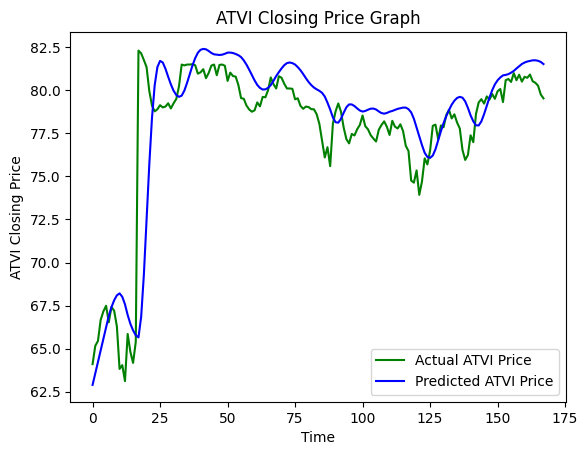

In [171]:
# Create Plot
plt.plot(truePrice, color = 'green', label = f"Actual {company} Price")
plt.plot(predictedPrices, color = 'blue', label = f"Predicted {company} Price")
plt.title(f"{company} Closing Price Graph")
plt.xlabel('Time')
plt.ylabel(f"{company} Closing Price")
plt.legend()
plt.show()

# Predicting Future


In [169]:
# Repeat again making the certain arrays
# Take all data from prediction days before and make array
futureData = [modelInputs[len(modelInputs) + 1 - predictionDays:len(modelInputs + 1), 0]]
futureData = np.array(futureData)
futureData = np.reshape(futureData, (futureData.shape[0], futureData.shape[1], 1))

# Make prediction
prediction = model.predict(futureData)
prediction = scaler.inverse_transform(prediction)

# Ouput prediction
print(f"Prediction: {prediction}")

1/1 [==============================] - 0s 33ms/step
Prediction: [[81.350044]]
